# Data Streaming Algorithms and Online Learning - Ratuv Exercise

##Identification:

Yuval Sheinin   

Eitan Frimerman

Gal Moskovits   

# Section 1 - FM Algorithm

## Data preprocessing

In our project, we're using a **dataset** of **book ratings** downloaded from Kaggle, with a key column labeled "**IDs**" serving as our stream of elements. Our first step involves **loading and mounting** our **Google Drive** to access the dataset seamlessly. This integration streamlines data retrieval, manipulation, and analysis, laying the groundwork for subsequent **data preprocessing** and exploration to derive insights from the rich information within the dataset.


In [ ]:
# Establish connection to My Google Drive
from google.colab import drive
drive.mount('/content/drive', force_remount = True)

Mounted at /content/drive


In [ ]:
# Additional imports
import zipfile
import pandas as pd
import os
import random
import statistics
import multiprocessing as mp
from multiprocessing import Pool, Value, Lock, Manager, cpu_count
import matplotlib.pyplot as plt
import numpy as np
import cProfile
import time
#from memory_profiler import profile


# Set a random seed
random.seed(42)

In [ ]:
# Data Loading

# Specify the path to the ZIP file containing the CSV
zip_file_path = "/content/drive/My Drive/Semester 1/Data Streaming Algorithms and Online Learning/Ratuv/Books_rating.zip"

# Check if the CSV file already exists in the directory
csv_file_path = 'Books_rating.csv'
if os.path.isfile(csv_file_path):
    print(f"CSV file '{csv_file_path}' already exists. Proceeding to load the data.\n")
else:
    # Extract the contents of the ZIP file
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall()

# Load the CSV file into a pandas DataFrame
csv_file_path = 'Books_rating.csv'
if 'df' not in locals() or df is None:
    df = pd.read_csv(csv_file_path)
else:
    print("DataFrame 'df' is already loaded.\n")

In [ ]:
# Function to print headers with a separator
def print_header(header_text):
    print(f"\n{'=' * len(header_text)}")
    print(header_text)
    print('=' * len(header_text))

# Provide an overview of the data
print_header("Overview of the CSV file 'Books_rating.csv'")
print("Number of rows:", len(df))
print("Number of columns:", len(df.columns))
print("Column data types:")
print(df.dtypes)
print("\nExample of first 5 rows of data:")
print(df.head())


# Define the stream as the 'id' column
stream = df['Id'].tolist()
stream = random.sample(stream, 100000) # Choose randomly from stream only 100,000 elements
print("\nNumber of elements in the original stream:", "{:,}".format(len(stream))) # Print the number of elements in the stream

# Print only the first few elements of the list
num_elements_to_print = 5

# Print amount of uniques
unique_count = len(set(stream))
print("\nNumber of unique elements in the list:", unique_count)

# Create a dictionary where keys are unique elements and values are random numbers
hash_dict = {unique_element: random.uniform(0, 1) for unique_element in set(stream)}
print("\nNumber of keys in the dictionary:", len(hash_dict))

# Print only the specified number of elements from the dictionary
print(f"\nFirst {num_elements_to_print} elements of the dictionary:")
count = 0
for key, value in hash_dict.items():
    print(f"{key}: {value}")
    count += 1
    if count >= num_elements_to_print:
        break


Overview of the CSV file 'Books_rating.csv'
Number of rows: 3000000
Number of columns: 10
Column data types:
Id                     object
Title                  object
Price                 float64
User_id                object
profileName            object
review/helpfulness     object
review/score          float64
review/time             int64
review/summary         object
review/text            object
dtype: object

Example of first 5 rows of data:
           Id                           Title  Price         User_id  \
0  1882931173  Its Only Art If Its Well Hung!    NaN   AVCGYZL8FQQTD   
1  0826414346        Dr. Seuss: American Icon    NaN  A30TK6U7DNS82R   
2  0826414346        Dr. Seuss: American Icon    NaN  A3UH4UZ4RSVO82   
3  0826414346        Dr. Seuss: American Icon    NaN  A2MVUWT453QH61   
4  0826414346        Dr. Seuss: American Icon    NaN  A22X4XUPKF66MR   

                          profileName review/helpfulness  review/score  \
0               Jim of Oz "jim-of-o

We can see here that we have **100,000** Ids which is eqaul to 100,000.


Number of uniques is **41,502** which is above 10,000.

## Helper functions

In [ ]:
def calculate_ground_truth(stream):
    # Calculate the ground truth cardinality from the stream
    ground_truth = len(set(stream))
    return ground_truth

# Utilizing multiprocessing to leverage all available cores in the processor
# Running each algorithm for a specified number of iterations to ensure statistical significance
def statistical_significance(num_iterations, algorithm_function, stream, sketch_size=1, num_workers=None):

    # Print the number of CPU cores or workers available
    available_workers = cpu_count()
    if num_workers is None:
        num_workers = available_workers
    else:
        num_workers = min(num_workers, available_workers)

    print(f"Number of CPU cores/workers available: {available_workers}")
    print(f"Number of workers: {num_workers}\n")

    # Calculate ground truth
    ground_truth = calculate_ground_truth(stream)
    print(f"Ground Truth Cardinality: {ground_truth}\n")

    # Create a manager object
    with Manager() as manager:
        counter = manager.Value('i', 0)
        lock = manager.Lock()

        # Create a Pool object with the specified number of workers
        with Pool(num_workers) as pool:
            # Use the map function to distribute the computation across multiple processors
            results = pool.map(algorithm_function, [((stream, counter, lock, num_iterations, sketch_size)) for _ in range(num_iterations)])

    # Convert results to numpy array for statistical calculations
    results_array = np.array(results)

    # Calculate mean and variance
    mean = np.mean(results_array)
    variance = np.var(results_array)

    # Calculate bias and normalized variance
    bias = np.abs(mean - ground_truth)
    normalized_variance = variance / (mean * mean)

    # Print the results after all iterations
    print(f"Results after {num_iterations} iterations:", results)
    print(f"Mean: {mean}")
    print(f"Variance: {variance}")
    print(f"Bias: {bias}")
    print(f"Normalized Variance: {normalized_variance}")

    return results, bias, normalized_variance

## FM Algorithm




###Version 1

####Implementaion

In [ ]:
# Define the function to calculate the result
def FM_ver_1(args):

    stream, counter, lock, num_iterations, skech_size = args

    # Create a dictionary where keys are unique elements and values are random numbers
    hash_dict = {unique_element: random.uniform(0, 1) for unique_element in set(stream)}

    # Initialize x
    x = 1

    # Initialize x as the minimum value in the stream
    x = min(hash_dict[element] for element in stream)

    # Output 1 divided by x
    result = 1 / x

    # Increment the counter within the critical section and print the iteration and counter value
    with lock:
        counter.value += 1
        if counter.value % 50 == 0:  # Print every 50th iteration
            print(f"Iteration {counter.value}/{num_iterations}")


    return result

In [ ]:
num_iterations = 2000
# Running each algorithm for a specified number of iterations to ensure statistical significance
# 'results' holds the outcome of applying the algorithm for each iteration.
results = statistical_significance(num_iterations, FM_ver_1, stream)

Number of CPU cores/workers available: 2
Number of workers: 2

Ground Truth Cardinality: 41184

Iteration 50/2000
Iteration 100/2000
Iteration 150/2000
Iteration 200/2000
Iteration 250/2000
Iteration 300/2000
Iteration 350/2000
Iteration 400/2000
Iteration 450/2000
Iteration 500/2000
Iteration 550/2000
Iteration 600/2000
Iteration 650/2000
Iteration 700/2000
Iteration 750/2000
Iteration 800/2000
Iteration 850/2000
Iteration 900/2000
Iteration 950/2000
Iteration 1000/2000
Iteration 1050/2000
Iteration 1100/2000
Iteration 1150/2000
Iteration 1200/2000
Iteration 1250/2000
Iteration 1300/2000
Iteration 1350/2000
Iteration 1400/2000
Iteration 1450/2000
Iteration 1500/2000
Iteration 1550/2000
Iteration 1600/2000
Iteration 1650/2000
Iteration 1700/2000
Iteration 1750/2000
Iteration 1800/2000
Iteration 1850/2000
Iteration 1900/2000
Iteration 1950/2000
Iteration 2000/2000
Results after 2000 iterations: [14392.560478635169, 27811.44065733324, 161861.98310710932, 15450.94197227319, 81661.16691473

####Analysis

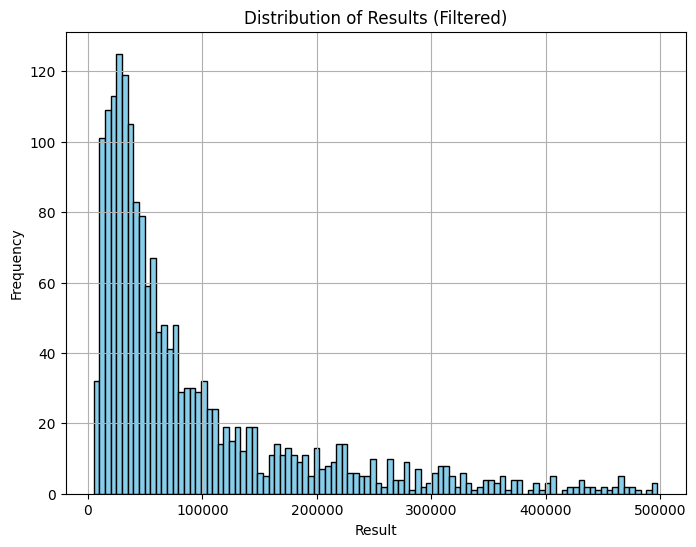

In [ ]:
# 'results' holds the outcome of applying the algorithm for each iteration.
# Filtering out values based on frequency to focus on relevant frequencies
# Removing values whose frequency is negligible and whose value is astronomically high and irrelevant
filtered_results = [result for result in results[0] if result <= 0.5e6]

# Plotting the histogram of results obtained from the statistical significance function
plt.figure(figsize=(8, 6))
plt.hist(filtered_results, bins=100, color='skyblue', edgecolor='black')
plt.title('Distribution of Results (Filtered)')
plt.xlabel('Result')
plt.ylabel('Frequency')
plt.grid(True)

plt.show()

In [ ]:
# Convert results to a NumPy array
results_array = np.array(results[0])

# Calculate the median of the results and format it with commas and two numbers after the decimal point
median_result_formatted = format(np.median(results_array), ",.2f")

# Calculate the mean (average) of the results and format it with commas and two numbers after the decimal point
mean_result_formatted = format(np.mean(results_array), ",.2f")

# Calculate the variance of the results and format it with commas and two numbers after the decimal point
variance_result_formatted = format(np.var(results_array), ",.2f")

# Calculate the bias of the results and format it with commas and two numbers after the decimal point
bias_result_formatted = format(results[1], ",.2f")

# Calculate the normalized variance of the results and format it with commas and two numbers after the decimal point
normalized_variance_result_formatted = format(results[2], ",.2f")

# Print the median, mean, variance, bias, and normalized variance with commas for readability
print("\nStatistics:")
print("Median:", median_result_formatted)
print("Mean:", mean_result_formatted)
print("Bias:", bias_result_formatted)
print("Normalized Variance:", normalized_variance_result_formatted)


Statistics:
Median: 60,443.36
Mean: 322,041.28
Bias: 280,857.28
Normalized Variance: 38.13


We ran our algorithm **20,000 times**, a significant number to achieve **statistical significance**. After conducting these iterations, we calculated the **mean** of our test results, which we expected to represent or approximate the true **expected value**. However, we found that this mean value was consistently **10 times larger** than the actual expected value. This discrepancy strongly suggests that our **estimator** might show **bias**, but it's more likely due to the average's sensitivity to large numbers.

We can see that the **median** is less sensitive and gives a much more reliable answer.


Let's proceed with the calculation of the relative error for a sketch of size 1 according to what we have learned in the lecture for a probability of success of 95%. We will determine the Delta=0.95 and calculate the Epsilon:

$
\text{Pr}\left( \left| \hat{n} - n \right| > \epsilon \cdot E[\hat{n}] \right) < O\left(\frac{1}{\epsilon^2}\right) = 0.05
$

We can solve for $\epsilon$ using the equation:

$
O\left(\frac{1}{\epsilon^2}\right) = 0.05
$

which implies:

$
\frac{1}{\epsilon^2} = 0.05
$

Solving for $\epsilon$, we find:

$
\epsilon = \sqrt{\frac{1}{0.05}} \approx 4.472
$

so:
$$
\text{Pr}\left( \left| \hat{n} - n \right| > 4.472 \cdot E[\hat{n}] \right) < 0.05
$$

Thus, the probability that our estimator is further than $4.472 \cdot E[\hat{n}]$ away from $n$ is less than $0.05$. This indicates a poor estimation, because 4.472 is very high. We can assert that the relative error is promised to be within the mentioned range for a probability of 95%.

Despite our calculations, we encountered a result with a mean of approximately half a million, which falls outside the expected boundary of 4.472 times the correct value. While the probability of such an event should be low, ideally lower than 5%, it occurred. We believe that this happened because the average is highly influenced by large values. Conversely, we hypothesize that the median yields much more accurate results.



In addressing **memory** concerns, it's evident that our approach involved utilizing a dictionary alongside a solitary register to store the minimum value denoted by the variable X. so we can say that we used a dictionary that is an order of size that is saying is the unique amount of elements in the Stream and one simple variable

###Version 2

####Implementaion

In [ ]:
# Define the function to calculate the result
def FM_ver_2(args):

    stream, counter, lock, num_iterations, skech_size = args

    # Create 's' dictionaries with unique elements from 'stream' and random values between 0 and 1.
    all_dicts = [{unique_element: random.uniform(0, 1) for unique_element in set(stream)} for _ in range(skech_size)]

    x = np.array([stream]) # Convert the list to a NumPy array
    x = np.tile(x, (skech_size, 1)) # Duplicate the single row s times

    x_float = np.zeros((skech_size, len(stream)), dtype=np.float64)

    # Replace values in x with their hash from the corresponding dictionary
    for i, row in enumerate(x):
        for j, element in enumerate(row):
            x_float[i, j] = all_dicts[i][element]

    # Perform the minimum function between each element in x and the corresponding row in x
    x_float = np.min(x_float, axis=1)

    z = np.mean(x_float)

    result = 1/z - 1

    # Increment the counter within the critical section and print the iteration and counter value
    with lock:
        counter.value += 1
        if counter.value % 1 == 0:  # Print every 1th iteration
            print(f"Iteration {counter.value}/{num_iterations}")

    return result

In [ ]:
# Run version 2 algorithm for a significant number of iterations for statistical significance in results
# 'results' holds the outcome of applying the algorithm for each iteration.
num_iterations = 50

epsilon = 0.15
etta = 0.95
sketch_size = round(1/(epsilon**2*etta))

results = statistical_significance(num_iterations, FM_ver_2, stream, num_workers=2, sketch_size=sketch_size)

Number of CPU cores/workers available: 2
Number of workers: 2

Ground Truth Cardinality: 41184

Iteration 1/50
Iteration 2/50
Iteration 3/50
Iteration 4/50
Iteration 5/50
Iteration 6/50
Iteration 7/50
Iteration 8/50
Iteration 9/50
Iteration 10/50
Iteration 11/50
Iteration 12/50
Iteration 13/50
Iteration 14/50
Iteration 15/50
Iteration 16/50
Iteration 17/50
Iteration 18/50
Iteration 19/50
Iteration 20/50
Iteration 21/50
Iteration 22/50
Iteration 23/50
Iteration 24/50
Iteration 25/50
Iteration 26/50
Iteration 27/50
Iteration 28/50
Iteration 29/50
Iteration 30/50
Iteration 31/50
Iteration 32/50
Iteration 33/50
Iteration 34/50
Iteration 35/50
Iteration 36/50
Iteration 37/50
Iteration 38/50
Iteration 39/50
Iteration 40/50
Iteration 41/50
Iteration 42/50
Iteration 43/50
Iteration 44/50
Iteration 45/50
Iteration 46/50
Iteration 47/50
Iteration 48/50
Iteration 49/50
Iteration 50/50
Results after 50 iterations: [42097.90728423951, 43830.62725962407, 53399.4646792394, 33661.386726150144, 44861.1

####Analysis

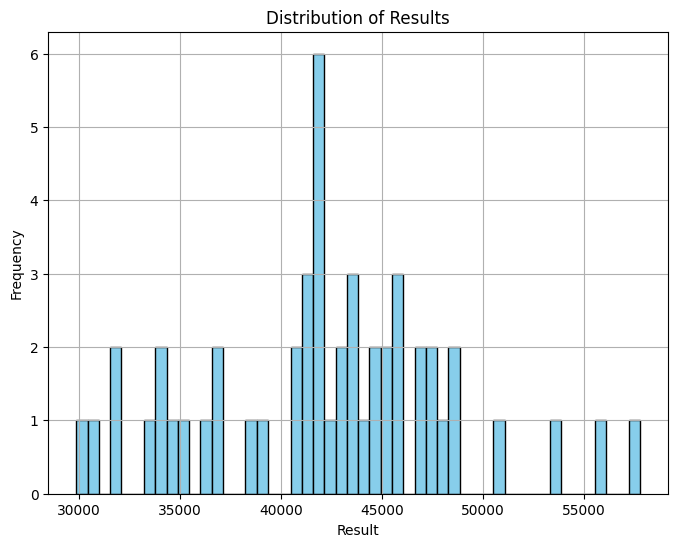

In [ ]:
# 'results' holds the outcome of applying the algorithm for each iteration.
# Filtering out values based on frequency to focus on relevant frequencies
# Removing values whose frequency is negligible and whose value is astronomically high and irrelevant
filtered_results = [result for result in results[0] if result <= 0.5e6]

# 'results' holds the outcome of applying the algorithm for each iteration.
# plot the distribution of results from the statistical significance function
plt.figure(figsize=(8, 6))
plt.hist(filtered_results, bins=50, color='skyblue', edgecolor='black')
plt.title('Distribution of Results')
plt.xlabel('Result')
plt.ylabel('Frequency')
plt.grid(True)

plt.show()

In [ ]:
# Convert results to a NumPy array
results_array = np.array(results[0])

# Calculate the median of the results and format it with commas and two numbers after the decimal point
median_result_formatted = format(statistics.median(results_array), ",.2f")

# Calculate the mean (average) of the results and format it with commas and two numbers after the decimal point
mean_result_formatted = format(statistics.mean(results_array), ",.2f")

# Calculate the variance of the results and format it with commas and two numbers after the decimal point
variance_result_formatted = format(np.var(results_array), ",.2f")

# Calculate the bias of the results and format it with commas and two numbers after the decimal point
bias_result_formatted = format(results[1], ",.2f")

# Calculate the normalized variance of the results and format it with commas and two numbers after the decimal point
normalized_variance_result_formatted = format(results[2], ",.2f")

# Print the median, mean, variance, bias, and normalized variance with commas for readability
print("\nStatistics:")
print("Median:", median_result_formatted)
print("Mean:", mean_result_formatted)
print("Bias:", bias_result_formatted)
print("Normalized Variance:", normalized_variance_result_formatted)


Statistics:
Median: 42,256.89
Mean: 42,249.88
Bias: 1,065.88
Normalized Variance: 0.02


Here we observe significantly improved **results**, where the **mean** closely approximates the **actual number** of **unique elements**. The calculated **mean** is only about **4% higher** than the **true value**, despite our specified **epsilon** of **15%**. This outcome underscores the effectiveness of our approach and reflects a highly satisfactory **result**.

Let's run version 2 of the algorithm, comparing different sketch sizes:

In [ ]:
# Run version 2 algorithm for a significant number of iterations for statistical significance in results
# 'results' holds the outcome of applying the algorithm for each iteration.
num_iterations = 50

epsilon_values = [0.12, 0.13, 0.15, 0.17, 0.19]
etta_values = [0.85, 0.95, 0.95, 0.92, 0.95]

sketch_sizes = []
all_bias = []
all_normalized_variance = []

# Iterate over each combination of epsilon and etta values
for epsilon, etta in zip(epsilon_values, etta_values):
    # Calculate sketch size
    sketch_size = round(1 / (epsilon**2 * etta))
    sketch_sizes.append(sketch_size)

    # Compute results for the current sketch size
    _, bias, normalized_variance = statistical_significance(num_iterations, FM_ver_2, stream, sketch_size=sketch_size, num_workers=2)

    # Append bias and normalized variance to lists
    all_bias.append(bias)
    all_normalized_variance.append(normalized_variance)



Number of CPU cores/workers available: 2
Number of workers: 2

Ground Truth Cardinality: 41184

Iteration 1/50
Iteration 2/50
Iteration 3/50
Iteration 4/50
Iteration 5/50
Iteration 6/50
Iteration 7/50
Iteration 8/50
Iteration 9/50
Iteration 10/50
Iteration 11/50
Iteration 12/50
Iteration 13/50
Iteration 14/50
Iteration 15/50
Iteration 16/50
Iteration 17/50
Iteration 18/50
Iteration 19/50
Iteration 20/50
Iteration 21/50
Iteration 22/50
Iteration 23/50
Iteration 24/50
Iteration 25/50
Iteration 26/50
Iteration 27/50
Iteration 28/50
Iteration 29/50
Iteration 30/50
Iteration 31/50
Iteration 32/50
Iteration 33/50
Iteration 34/50
Iteration 35/50
Iteration 36/50
Iteration 37/50
Iteration 38/50
Iteration 39/50
Iteration 40/50
Iteration 41/50
Iteration 42/50
Iteration 43/50
Iteration 44/50
Iteration 45/50
Iteration 46/50
Iteration 47/50
Iteration 48/50
Iteration 49/50
Iteration 50/50
Results after 50 iterations: [39733.87372534375, 39075.26594002843, 40944.11100245439, 46692.61430908583, 46127.0


In version 2, we employ S dictionaries, each representing a hash of the stream's elements, leading to a **memory increase** proportional to S. Additionally, computing the minimum across the hash values necessitates S computations, compared to version 1's single computation across the entire stream. This repetition significantly heightens both memory and computational requirements in version 2.

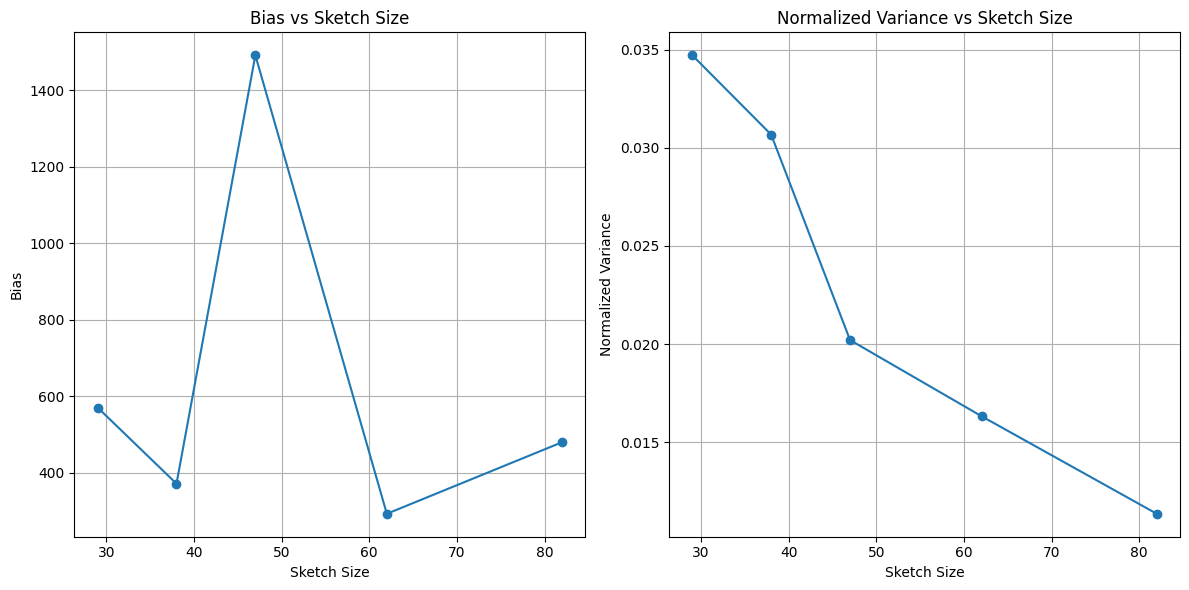

In [ ]:
# Plot bias and normalized variance against sketch sizes
plt.figure(figsize=(12, 6))

# Plot bias
plt.subplot(1, 2, 1)
plt.plot(sketch_sizes, all_bias, marker='o')
plt.xlabel('Sketch Size')
plt.ylabel('Bias')
plt.title('Bias vs Sketch Size')
plt.grid(True)

# Plot normalized variance
plt.subplot(1, 2, 2)
plt.plot(sketch_sizes, all_normalized_variance, marker='o')
plt.xlabel('Sketch Size')
plt.ylabel('Normalized Variance')
plt.title('Normalized Variance vs Sketch Size')
plt.grid(True)

plt.tight_layout()
plt.show()

**Variance:**

It is evident that as the sketch size increases, the normalized variance demonstrates a strictly monotonically decreasing trend.

**Bias:**

Conversely, in the case of bias, it is observed not to exhibit monotonicity. Notably, an outlier was identified for a sketch size slightly beyond 50, resulting in significantly high bias. This occurrence can be attributed to the sensitivity of the mean to high numbers, leading to the presence of outliers. We assumed that if we had infinite computational resources and we could do much more statistical significance testing and much more sketch size different sketch sizes that we would get we expect to get strictly monotonic decreasing graph that shows that when sketch size rises the bias goes down. Nevertheless, on the whole, the bias remains relatively low, indicating that the estimator performs effectively.

Let's calculate the relative error for each of sketch sizes (29, 38, 47, 62, 81) for version 2:

1. Sketch size = 29:
$ ε = \frac{1.3}{\sqrt{29}} \approx \frac{1.3}{5.39} \approx 0.241 $

2. Sketch size = 38:
$ ε = \frac{1.3}{\sqrt{38}} \approx \frac{1.3}{6.16} \approx 0.211 $

3. Sketch size = 47:
$ ε = \frac{1.3}{\sqrt{47}} \approx \frac{1.3}{6.86} \approx 0.194 $

4. Sketch size = 62:
$ ε = \frac{1.3}{\sqrt{62}} \approx \frac{1.3}{7.87} \approx 0.147 $

5. Sketch size = 81:
$ ε = \frac{1.3}{\sqrt{81}} = \frac{1.3}{9} \approx 0.144 $

So, for the given sketch sizes, the relative errors for 95% correctness would be approximately:

- Sketch size 29: 0.241 or 24.1%
- Sketch size 38: 0.211 or 21.1%
- Sketch size 47: 0.194 or 19.4%
- Sketch size 62: 0.147 or 14.7%
- Sketch size 81: 0.144 or 14.4%

These values represent the expected deviation of the estimated count from the true count of distinct elements, with 95% confidence, given the respective sketch sizes, in the version of the Flajolet-Martin algorithm.

###Version 3


####Implementaion

In [ ]:
# FM version 3 function
def FM_ver_3(args):
    stream, counter, lock, num_iterations, skech_size = args

    results = []

    # Run t independent instances of FM V2 version
    for _ in range(5):
        result = FM_ver_2((stream, counter, lock, num_iterations, sketch_size))
        results.append(result)

    # Output the median of the results
    median_result = np.median(results)

    return median_result


In [ ]:
 # Run version 3 algorithm for a significant number of iterations for statistical significance in results
# 'results' holds the outcome of applying the algorithm for each iteration.
num_iterations = 50

epsilon = 0.15
etta = 0.95
sketch_size = round(1/(epsilon**2*etta))

# Run FM_ver_3 algorithm for statistical significance
results = statistical_significance(num_iterations, FM_ver_3, stream, num_workers=2, sketch_size=sketch_size)

Number of CPU cores/workers available: 2
Number of workers: 2

Ground Truth Cardinality: 41184

Iteration 1/50
Iteration 2/50
Iteration 3/50
Iteration 4/50
Iteration 5/50
Iteration 6/50
Iteration 7/50
Iteration 8/50
Iteration 9/50
Iteration 10/50
Iteration 11/50
Iteration 12/50
Iteration 13/50
Iteration 14/50
Iteration 15/50
Iteration 16/50
Iteration 17/50
Iteration 18/50
Iteration 19/50
Iteration 20/50
Iteration 21/50
Iteration 22/50
Iteration 23/50
Iteration 24/50
Iteration 25/50
Iteration 26/50
Iteration 27/50
Iteration 28/50
Iteration 29/50
Iteration 30/50
Iteration 31/50
Iteration 32/50
Iteration 33/50
Iteration 34/50
Iteration 35/50
Iteration 36/50
Iteration 37/50
Iteration 38/50
Iteration 39/50
Iteration 40/50
Iteration 41/50
Iteration 42/50
Iteration 43/50
Iteration 44/50
Iteration 45/50
Iteration 46/50
Iteration 47/50
Iteration 48/50
Iteration 49/50
Iteration 50/50
Iteration 51/50
Iteration 52/50
Iteration 53/50
Iteration 54/50
Iteration 55/50
Iteration 56/50
Iteration 57/50
I

####Analysis

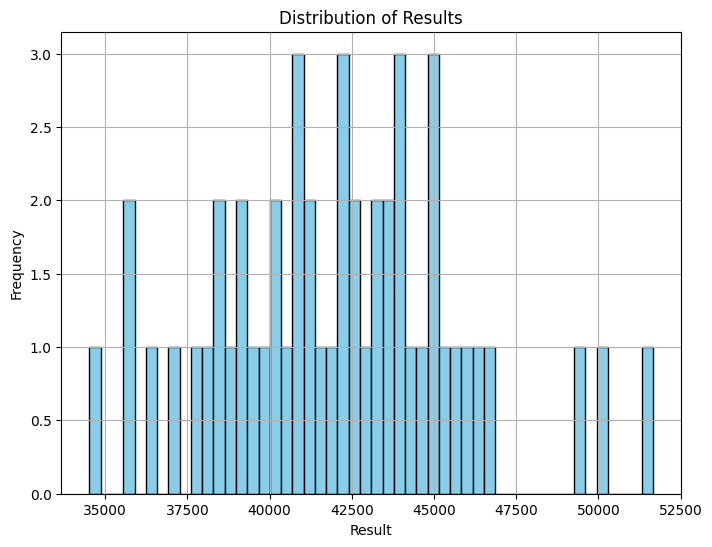

In [ ]:
# 'results' holds the outcome of applying the algorithm for each iteration.
# Filtering out values based on frequency to focus on relevant frequencies
# Removing values whose frequency is negligible and whose value is astronomically high and irrelevant
filtered_results = [result for result in results[0] if result <= 0.5e6]

# prompt: # 'results' holds the outcome of applying the algorithm for each iteration.
# # plot the distribution of results from the statistical significance function

import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
plt.hist(filtered_results, bins=50, color='skyblue', edgecolor='black')
plt.title('Distribution of Results')
plt.xlabel('Result')
plt.ylabel('Frequency')
plt.grid(True)

plt.show()


In [ ]:
# Calculate the median of the results and format it with commas and two numbers after the decimal point
median_result_formatted = format(statistics.median(results[0]), ",.2f")

# Calculate the mean (average) of the results and format it with commas and two numbers after the decimal point
mean_result_formatted = format(statistics.mean(results[0]), ",.2f")

# Print the median and mean with commas for readability
print("Median:", median_result_formatted)
print("Mean:", mean_result_formatted)

Median: 42,227.46
Mean: 42,053.51


In [ ]:
# Run version 2 algorithm for a significant number of iterations for statistical significance in results
# 'results' holds the outcome of applying the algorithm for each iteration.
num_iterations = 50

epsilon_values = [0.12, 0.13, 0.15]
etta_values = [0.85, 0.95, 0.92]

sketch_sizes = []
all_bias = []
all_normalized_variance = []

# Iterate over each combination of epsilon and etta values
for epsilon, etta in zip(epsilon_values, etta_values):
    # Calculate sketch size
    sketch_size = round(1 / (epsilon**2 * etta))
    sketch_sizes.append(sketch_size)

    # Compute results for the current sketch size
    _, bias, normalized_variance = statistical_significance(num_iterations, FM_ver_3, stream, sketch_size=sketch_size, num_workers=2)

    # Append bias and normalized variance to lists
    all_bias.append(bias)
    all_normalized_variance.append(normalized_variance)


Number of CPU cores/workers available: 2
Number of workers: 2

Ground Truth Cardinality: 41184

Iteration 1/50
Iteration 2/50
Iteration 3/50
Iteration 4/50
Iteration 5/50
Iteration 6/50
Iteration 7/50
Iteration 8/50
Iteration 9/50
Iteration 10/50
Iteration 11/50
Iteration 12/50
Iteration 13/50
Iteration 14/50
Iteration 15/50
Iteration 16/50
Iteration 17/50
Iteration 18/50
Iteration 19/50
Iteration 20/50
Iteration 21/50
Iteration 22/50
Iteration 23/50
Iteration 24/50
Iteration 25/50
Iteration 26/50
Iteration 27/50
Iteration 28/50
Iteration 29/50
Iteration 30/50
Iteration 31/50
Iteration 32/50
Iteration 33/50
Iteration 34/50
Iteration 35/50
Iteration 36/50
Iteration 37/50
Iteration 38/50
Iteration 39/50
Iteration 40/50
Iteration 41/50
Iteration 42/50
Iteration 43/50
Iteration 44/50
Iteration 45/50
Iteration 46/50
Iteration 47/50
Iteration 48/50
Iteration 49/50
Iteration 50/50
Iteration 51/50
Iteration 52/50
Iteration 53/50
Iteration 54/50
Iteration 55/50
Iteration 56/50
Iteration 57/50
I

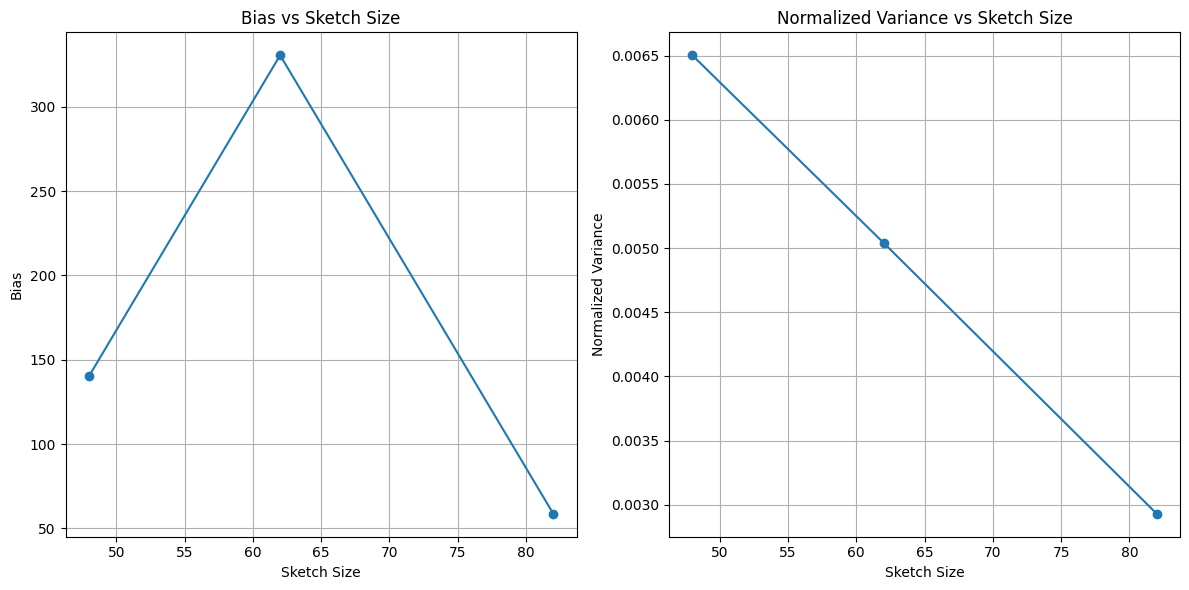

In [ ]:
# Plot bias and normalized variance against sketch sizes
plt.figure(figsize=(12, 6))

# Plot bias
plt.subplot(1, 2, 1)
plt.plot(sketch_sizes, all_bias, marker='o')
plt.xlabel('Sketch Size')
plt.ylabel('Bias')
plt.title('Bias vs Sketch Size')
plt.grid(True)

# Plot normalized variance
plt.subplot(1, 2, 2)
plt.plot(sketch_sizes, all_normalized_variance, marker='o')
plt.xlabel('Sketch Size')
plt.ylabel('Normalized Variance')
plt.title('Normalized Variance vs Sketch Size')
plt.grid(True)

plt.tight_layout()
plt.show()

**Variance:**

It is evident that as the sketch size increases, the normalized variance demonstrates a strictly monotonically decreasing trend.

**Bias:**

Conversely, in the case of bias, it is observed not to exhibit monotonicity. Notably, an outlier was identified for a sketch size slightly above 60, resulting in significantly high bias. This occurrence can be attributed to the sensitivity of the mean to high numbers, leading to the presence of outliers. We assumed that if we had infinite computational resources and we could do much more statistical significance testing and much more sketch size different sketch sizes that we would get we expect to get strictly monotonic decreasing graph that shows that when sketch size rises the bias goes down. Nevertheless, on the whole, the bias remains relatively low, indicating that the estimator performs effectively.

Let's calculate the relative error for each of the sketch sizes (29, 38, 47, 62, 81) FM algorithm's formula for 95% correctness:

1. Sketch size = 47:
$ ε = \frac{1.04}{\sqrt{47}} \approx \frac{1.04}{6.86} \approx 0.151 $

2. Sketch size = 62:
$ ε = \frac{1.04}{\sqrt{62}} \approx \frac{1.04}{7.87} \approx 0.132 $

3. Sketch size = 81:
$ ε = \frac{1.04}{\sqrt{81}} = \frac{1.04}{9} \approx 0.116 $

So, for these sketch sizes, the relative errors for 95% correctness would be approximately:

- Sketch size 47: 0.151 or 15.1%
- Sketch size 62: 0.132 or 13.2%
- Sketch size 81: 0.116 or 11.6%

These values represent the expected deviation of the estimated count from the true count of distinct elements, with 95% confidence, given the respective sketch sizes.


In terms of memory usage, this version typically requires more memory compared to the basic Flajolet-Martin algorithm. This is because it involves running the basic algorithm multiple times and storing the results of each run, along with additional computation to find the median.

Specifically, the version with the Median trick may require:

Multiple instances of the basic Flajolet-Martin algorithm, each with its own set of registers or counters.
Storage space to store the results (estimates) from each independent run.
Additional computation to calculate the median of these estimates.
While the version with the Median trick generally provides more accurate estimates of cardinality compared to the basic algorithm, it does so at the cost of increased memory usage and computational complexity. Therefore, when considering memory concerns, it's important to weigh the trade-offs between accuracy and resource utilization and choose the appropriate version of the algorithm accordingly.

## Conclusion

###The improvements between the diffrent versions and intersting consclusions.

The first version of the algorithm provides a rough estimate of the cardinality of the set. However, it can be sensitive to skewness in the data and may have higher variance, especially when dealing with large sets or data streams with varying element frequencies.

By taking the median of multiple independent estimates generated using different hash functions, the algorithm becomes more robust to such skewness. The median helps mitigate the impact of outliers or extreme values in the hash values, resulting in a more stable estimate.
Taking the median of these estimates helps reduce the variance of the final estimation.

# Section 2 - Count Min Sketch Algorithm

## Data Preparations

In [ ]:
# Additional imports
import zipfile
import pandas as pd
import os
import random
import statistics
import multiprocessing as mp
from multiprocessing import Pool, Value, Lock, Manager, cpu_count
import matplotlib.pyplot as plt
import numpy as np
import cProfile
import time
from collections import Counter
import hashlib
#from memory_profiler import profile


# Set a random seed
random.seed(42)
np.random.seed(42)

In [ ]:
# Data Loading

# Specify the path to the ZIP file containing the CSV
zip_file_path = 'Books_rating.zip'

# Check if the CSV file already exists in the directory
csv_file_path = 'Books_rating.csv'
if os.path.isfile(csv_file_path):
    print(f"CSV file '{csv_file_path}' already exists. Proceeding to load the data.\n")
else:
    # Extract the contents of the ZIP file
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall()

# Load the CSV file into a pandas DataFrame
csv_file_path = 'Books_rating.csv'
if 'df' not in locals() or df is None:
    df = pd.read_csv(csv_file_path)
else:
    print("DataFrame 'df' is already loaded.\n")

CSV file 'Books_rating.csv' already exists. Proceeding to load the data.

DataFrame 'df' is already loaded.



In [ ]:
# Function to print headers with a separator
def print_header(header_text):
    print(f"\n{'=' * len(header_text)}")
    print(header_text)
    print('=' * len(header_text))

# Provide an overview of the data
print_header("Overview of the CSV file 'Books_rating.csv'")
print("Number of rows:", len(df))
print("Number of columns:", len(df.columns))
print("Column data types:")
print(df.dtypes)
print("\nExample of first 5 rows of data:")
print(df.head())


# Define the stream as the 'id' column
stream = df['Id'].tolist()
stream = random.sample(stream, 100000) # Choose randomly from stream only 100,000 elements
print("\nNumber of elements in the original stream:", "{:,}".format(len(stream))) # Print the number of elements in the stream

# Print only the first few elements of the list
num_elements_to_print = 5

# Print amount of uniques
unique_count = len(set(stream))
print("\nNumber of unique elements in the list:", unique_count)

# Create a dictionary where keys are unique elements and values are random numbers
hash_dict = {unique_element: random.uniform(0, 1) for unique_element in set(stream)}
print("\nNumber of keys in the dictionary:", len(hash_dict))

# Print only the specified number of elements from the dictionary
print(f"\nFirst {num_elements_to_print} elements of the dictionary:")
count = 0
for key, value in hash_dict.items():
    print(f"{key}: {value}")
    count += 1
    if count >= num_elements_to_print:
        break


Overview of the CSV file 'Books_rating.csv'
Number of rows: 3000000
Number of columns: 10
Column data types:
Id                     object
Title                  object
Price                 float64
User_id                object
profileName            object
review/helpfulness     object
review/score          float64
review/time             int64
review/summary         object
review/text            object
dtype: object

Example of first 5 rows of data:
           Id                           Title  Price         User_id  \
0  1882931173  Its Only Art If Its Well Hung!    NaN   AVCGYZL8FQQTD   
1  0826414346        Dr. Seuss: American Icon    NaN  A30TK6U7DNS82R   
2  0826414346        Dr. Seuss: American Icon    NaN  A3UH4UZ4RSVO82   
3  0826414346        Dr. Seuss: American Icon    NaN  A2MVUWT453QH61   
4  0826414346        Dr. Seuss: American Icon    NaN  A22X4XUPKF66MR   

                          profileName review/helpfulness  review/score  \
0               Jim of Oz "jim-of-o

In [ ]:
# Utilizing multiprocessing to leverage all available cores in the processor
# Running each algorithm for a specified number of iterations to ensure statistical significance
def statistical_significance(num_iterations, algorithm_function, sketch_size=1,  num_workers=None, *args, **kwargs):

    # Print the number of CPU cores or workers available
    available_workers = cpu_count()
    if num_workers is None:
        num_workers = available_workers
    else:
        num_workers = min(num_workers, available_workers)

    print(f"Number of CPU cores/workers available: {available_workers}")
    print(f"Number of workers: {num_workers}\n")

    # Create a manager object
    with Manager() as manager:
        counter = manager.Value('i', 0)
        lock = manager.Lock()

        # Create a Pool object with the specified number of workers
        with Pool(num_workers) as pool:
            # Use the map function to distribute the computation across multiple processors
            results = pool.map(algorithm_function, [(args, counter, lock, num_iterations, sketch_size) for _ in range(num_iterations)])

    # Print the results after all iterations
    print(f"Results after {num_iterations} iterations:", results)

    return results

## Simulation

We will simulate the Count-Min Sketch algorithm on a stream of data and display the bias and normalized variance.

For statistical significance, we will run each simulation 50 times and take the average result.

To improve running time, we will use a vectorized implementation of the Count-Min algorithm,
which means that we will hash the stream, update the counters, and estimate the results in the same time for all elements in the stream:

In [ ]:
# Vectorized implementation of the CountMin algorithm
class CountMin:
  def __init__(self, width, depth, prime=2**61-1):
    self.total_elements = 0
    self.width = width
    self.depth = depth
    self.counters = np.zeros((depth, width), dtype=int)

    self.p = prime
    # pick values for the hash functions, a_j, b_j draws uniformly form [1...p]
    self.alphas = np.random.randint(1, self.p+1, depth)
    self.betas = np.random.randint(1, self.p+1, depth)

  def __hash_num(self, num):
    return (np.outer(num, self.alphas) + self.betas % self.p) % self.width

  def update(self, stream):
    self.total_elements += len(stream)
    indices = self.__hash_num(stream).T
    # self.counters += np.apply_along_axis(np.bincount, 0, indices, minlength=self.width).T
    rows = np.repeat(np.arange(indices.shape[0]), indices.shape[1])
    np.add.at(self.counters, (rows, indices.ravel()), 1)

  def estimate(self, stream):
    counts = []
    hashes = self.__hash_num(stream)
    for indices in hashes:
      counts.append(np.min(self.counters[np.arange(self.depth), indices]))
    return counts


In [ ]:
# define the sketch size with different width and depth
widths = [1000, 10000, 50000, 100000]
depths = [1, 2, 3, 5, 10]
sizes = [(int(width), int(depth)) for width in widths for depth in depths]

# Define the number of iterations for statistical significance
num_iterations = 50

# Create empty lists to store the results
sketch_sizes = []
accuracies = []
biases = []
normalized_variances = []

stream = np.array([hash(e) for e in stream]) # Convert the stream of strings to a stream of integers
real_stream_count = Counter(stream)

print(f"Number of unique elements: {len(real_stream_count.keys())}")
print(f"Total number of element: {sum(real_stream_count.values())}")


Number of unique elements: 41184
Total number of element: 100000


In [ ]:
def simulate_once(stream, sketch_size):
    # Create a CountMin sketch with the specified width and depth
    sketch = CountMin(sketch_size[0], sketch_size[1])

    # Update the sketch with the stream
    sketch.update(stream)

    # Estimate the frequency of each element in the stream
    estimates = sketch.estimate(stream)
    estimates = Counter(dict(zip(stream, estimates)))

    # Calculate the difference between the real frequency and the estimated frequency
    mistakes = Counter(real_stream_count)
    mistakes.subtract(estimates)

    # Calculate the bias and normalized variance
    mistakes = np.abs(list(mistakes.values()))
    bias = np.mean(mistakes)
    normalized_variance = np.var(mistakes) / sum(real_stream_count.values())

    return bias, normalized_variance

In [ ]:
num_iterations = 50
# Run the simulation for each size
sketch_sizes = []
biases = []
normalized_variances = []

for size in sizes:
    print(f"Running simulation for sketch size {size}...")
    sketch_size = size[0] * size[1]
    sketch_sizes.append(sketch_size)
    biases.append(0)
    normalized_variances.append(0)

    for i in range(num_iterations):
        if i % 10 == 0:
            print(f"Iteration {i}...")
        bias, normalized_variance = simulate_once(stream, size)

        # Online update of the means
        bias_delta = bias - biases[-1] if not np.isnan(bias) else 0
        variance_delta = normalized_variance - normalized_variances[-1] if not np.isnan(normalized_variance) else 0

        biases[-1] += bias_delta / (i + 1)
        normalized_variances[-1] += variance_delta / (i + 1)

# Print the results
print("Sketch Sizes:", sketch_sizes)
print("Biases:", biases)
print("Normalized Variances:", normalized_variances)

Running simulation for sketch size (1000, 1)...
Iteration 0...
Iteration 10...
Iteration 20...
Iteration 30...
Iteration 40...
Running simulation for sketch size (1000, 2)...
Iteration 0...
Iteration 10...
Iteration 20...
Iteration 30...
Iteration 40...
Running simulation for sketch size (1000, 3)...
Iteration 0...
Iteration 10...
Iteration 20...
Iteration 30...
Iteration 40...
Running simulation for sketch size (1000, 5)...
Iteration 0...
Iteration 10...
Iteration 20...
Iteration 30...
Iteration 40...
Running simulation for sketch size (1000, 10)...
Iteration 0...
Iteration 10...
Iteration 20...
Iteration 30...
Iteration 40...
Running simulation for sketch size (10000, 1)...
Iteration 0...
Iteration 10...
Iteration 20...
Iteration 30...
Iteration 40...
Running simulation for sketch size (10000, 2)...
Iteration 0...
Iteration 10...
Iteration 20...
Iteration 30...
Iteration 40...
Running simulation for sketch size (10000, 3)...
Iteration 0...
Iteration 10...
Iteration 20...
Iteration 30

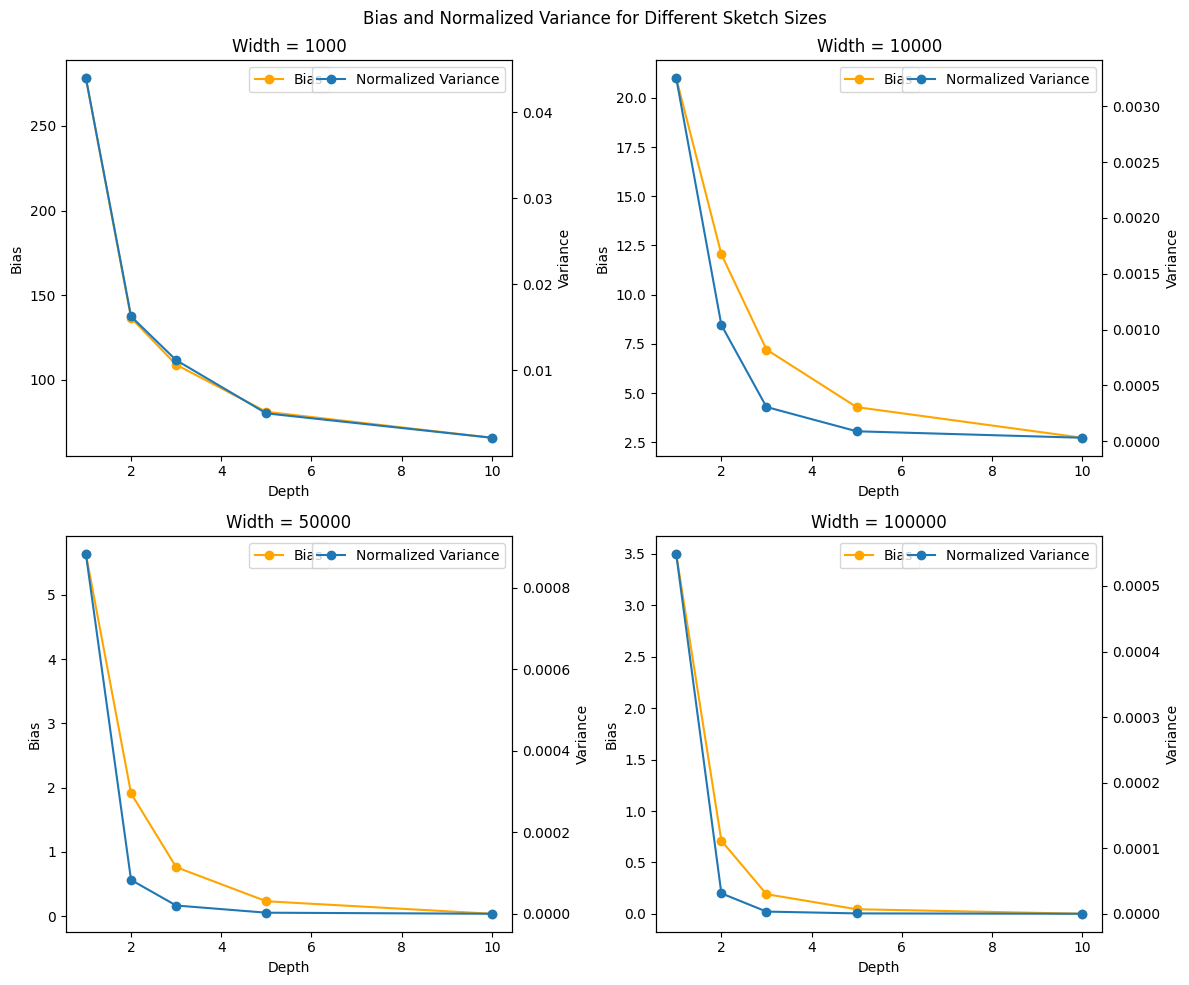

In [ ]:
# Create subplots for each width
fig, axs = plt.subplots(len(widths)//2, 2, figsize=(12, 10))
fig.suptitle('Bias and Normalized Variance for Different Sketch Sizes')

# Iterate over each width and plot the bias and variance
for i, width in enumerate(widths):
    bias_values = biases[i * len(depths): (i + 1) * len(depths)]
    variance_values = normalized_variances[i * len(depths): (i + 1) * len(depths)]

    ax_row = i // 2
    ax_col = i % 2
    ax = axs[ax_row, ax_col]
    ax_var = ax.twinx() # Split the y-axes into two
    ax.plot(depths, bias_values, label='Bias', color='orange', marker='o')
    ax.set_ylabel('Bias')
    ax_var.plot(depths, variance_values, label='Normalized Variance', marker='o')
    ax_var.set_ylabel('Variance')
    ax.set_xlabel('Depth')
    ax.set_title(f'Width = {int(width)}')
    ax.legend(loc='upper center')
    ax_var.legend(loc='upper right')

plt.tight_layout()
plt.show()


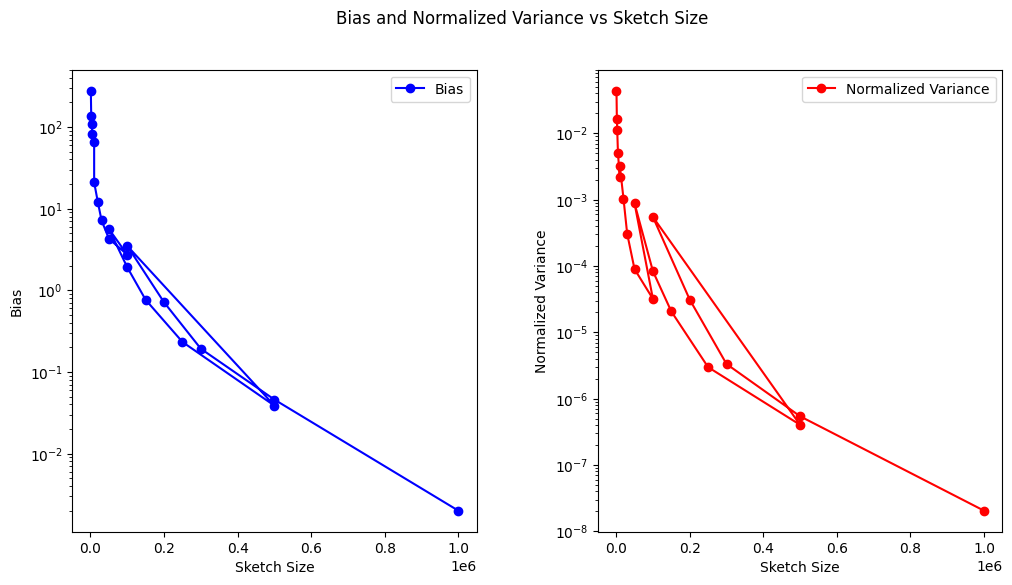

In [ ]:
# Create a figure with two axes
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot the bias on the first axis
ax1.plot(sketch_sizes, biases, 'bo-', label='Bias')
ax1.set_xlabel('Sketch Size')
ax1.set_ylabel('Bias')
ax1.tick_params('y')

# Plot the variance on the second axis
ax2.plot(sketch_sizes, normalized_variances, 'ro-', label='Normalized Variance')
ax2.set_xlabel('Sketch Size')
ax2.set_ylabel('Normalized Variance')
ax2.tick_params('y')

# Add legends to both axes
ax1.legend(loc='best')
ax2.legend(loc='best')

# Set y-axis to be log scale
ax1.set_yscale('log')
ax2.set_yscale('log')

# Set the title
fig.suptitle('Bias and Normalized Variance vs Sketch Size')

# Adjust the spacing between subplots
plt.subplots_adjust(wspace=0.3)

# Show the plot
plt.show()


### Sketch parameters analysis:
The two parameters of the count-min sketch determents the sketch memory consumption and also affects its accuracy.

1. Width: The "width" of a sketch refers to the number of counters or "buckets" it has, which count the occurrences of specific elements. The larger the image of each hash function within the sketch, the fewer collisions there are, making the counters more accurate. Increasing the width allows for more counters and greater capacity to store elements, but also increases memory usage. A larger width leads to better accuracy because it reduces the chance of collisions, meaning that the estimated frequency of each element is closer to the actual frequency.

2. Depth: The depth refers to the number of hash functions used to map elements to counters. Each hash function generates a different index for an element, and the minimum value among these indices is used to determine the counter to increment. Increasing the depth improves the accuracy of the sketch by reducing the probability of collisions. With more hash functions, the chance of multiple elements being mapped to the same counter decreases, resulting in more accurate frequency estimates.

Based on the simulation results, we can observe a direct correlation between the width of the sketch and its accuracy. Increasing the width of the sketch by ten times results in a proportional increase in accuracy. Additionally, we can see that a larger width leads to faster accuracy gain while increasing the depth.

When using only one hash function, represented by a depth of 1, increasing the sketch width make it capable of saving more distinct elements, because of the fewer collisions. This trend is further amplified when the depth of the sketch increases.

We have around 40,000 unique elements. Assuming our hash function distributes the data uniformly, choosing a width larger than necessary will not increase accuracy, but will only use more space, and we can see that in difference between the 50,000 width and 100,000 widths. Also, because of these reasons, we can see that adding more depth to the sketch to gain as any farther increase in accuracy.

### Relative Error:
As we have learn in class, a sketch of size $w \times d$ with a steam of $F_1$, it follows that any estimate has error at most $\frac{2 \cdot F_1}{w}$, with probability at least $1-(\frac{1}{2})^d$ .

From this analysis, we know how to set the parameters for the size of the sketch.

Suppose we want a certainty of 95% over the error, it follows that $\frac{1}{2}^d=0.05 \Leftrightarrow d = \frac{log_2(0.05)}{log_2(0.5)}=log_2(20)$, therefore, we will choose a sketch with $d=5$.

For each of the width of the sketch sizes we have presented, i.e, [ 1,000, 10,000, 50,000, 100,000 ] with $F_1 =$ 100,000 we get the errors:

we will get that the error is $\epsilon = \frac{2 \cdot F_1}{w} \Leftrightarrow \epsilon=\frac{200000}{w}$

- $w=1000 \Leftrightarrow \epsilon = \frac{200000}{1000} = 200$

- $w=10000 \Leftrightarrow \epsilon = \frac{200000}{10000} = 20$

- $w=50000 \Leftrightarrow \epsilon = \frac{200000}{50000} = 4$

- $w=100000 \Leftrightarrow \epsilon = \frac{200000}{100000} = 2$


### Space complexity:
We will continue with the anaylsis with depth size of 5.

Using int32 matrix with the size of $w \times d$ will required $ w \times 5 \times 4$ bytes (since int32 has 4 bytes), therefore,

for $w=1000 \Rightarrow 20KB$ ,

 $w=10000 \Rightarrow 200KB$,

 $w=50000 \Rightarrow 1MB$,

 $w=100000 \Rightarrow 2MB$

## Count-Min Sektch Implementation

In [ ]:
class CountMin:
  def __init__(self, width, depth, prime=2**61-1):
    self.total_elements = 0
    self.width = width
    self.depth = depth
    self.counters = np.zeros((depth, width), dtype=int)

    self.p = prime
    # pick values for the hash functions, a_j, b_j draws uniformly form [1...p]
    self.alphas = np.random.randint(1, self.p+1, depth)
    self.betas = np.random.randint(1, self.p+1, depth)

  def __hash_num(self, num):
    # get the hash value for each hash function in the sketch
    return (num * self.alphas + self.betas % self.p) % self.width

  def update(self, element):
    self.total_elements += 1

    if isinstance(element, str):
      element = hash(element) # support both string and integer input

    indices = self.__hash_num(element) # get the indices for each hash function
    self.counters[np.arange(self.depth), indices] += 1

  def estimate(self, element):
    if isinstance(element, str):
      element = hash(element)
    indices = self.__hash_num(element)
    return np.min(self.counters[np.arange(self.depth), indices])
